<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets
import torch
from torchvision import transforms
import numpy as np
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 53185479.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
next(iter(train_loader))

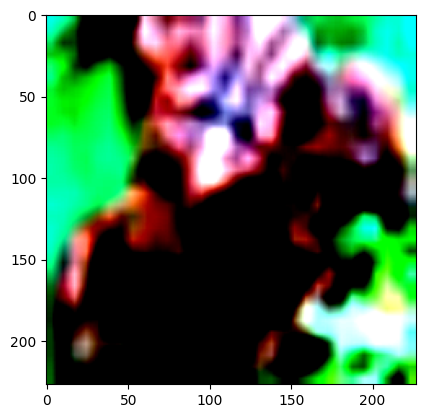

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt 
examples = next(iter(train_loader))

plt.imshow(examples[0][4].permute(1,2,0))

In [ ]:
 num_classes = len(np.unique(next(iter(train_loader))[1].detach().numpy()))

In [ ]:
from torch.nn.modules import activation

class AlexNet(nn.Module):
  def __init__(self,num_classes):
    super(AlexNet,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4,),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.conv2 = nn.Sequential(
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.conv3 = nn.Sequential(
    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    )

    self.conv4 = nn.Sequential(
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    )

    self.conv5 = nn.Sequential(
    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    nn.ReLU(),)
    self.fc = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(9216, 4096),
          nn.ReLU())
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU())
    
    self.fc2= nn.Sequential(
        nn.Linear(4096, num_classes))
      
  def forward(self, input):
      output = self.conv1(input)
      output = self.conv2(output)
      output = self.conv3(output)
      output = self.conv4(output)
      output = self.conv5(output)
      output = output.reshape(output.size(0), -1)
      output = self.fc(output)
      output = self.fc1(output)
      output = self.fc2(output)
      return output

   
    


    
  


In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

alex_net = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alex_net.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)
total_step


704

In [ ]:
alex_net

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  

In [ ]:
img_batch, label_batch = next(iter(train_loader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")
img_single.shape
# 3. Perform a forward pass on a single image
alex_net.eval()
with torch.inference_mode():
    pred = alex_net(img_single.to(device))
    
# # 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape: torch.Size([1, 3, 227, 227])

Output logits:
tensor([[ 0.0127,  0.0049, -0.0104, -0.0059,  0.0044,  0.0098, -0.0109, -0.0130,
         -0.0031,  0.0046]], device='cuda:0')

Output prediction probabilities:
tensor([[0.1013, 0.1006, 0.0990, 0.0995, 0.1005, 0.1011, 0.0990, 0.0988, 0.0998,
         0.1005]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
5


In [ ]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = alex_net(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = alex_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 


Epoch [1/20], Step [704/704], Loss: 1.1263
Accuracy of the network on the 5000 validation images: 44.34 %
Epoch [2/20], Step [704/704], Loss: 1.3189
Accuracy of the network on the 5000 validation images: 48.68 %
Epoch [3/20], Step [704/704], Loss: 1.1333
Accuracy of the network on the 5000 validation images: 55.4 %
Epoch [4/20], Step [704/704], Loss: 1.6166
Accuracy of the network on the 5000 validation images: 60.2 %
Epoch [5/20], Step [704/704], Loss: 0.8266
Accuracy of the network on the 5000 validation images: 63.86 %
Epoch [6/20], Step [704/704], Loss: 0.8631
Accuracy of the network on the 5000 validation images: 64.8 %
Epoch [7/20], Step [704/704], Loss: 0.7749
Accuracy of the network on the 5000 validation images: 62.8 %
Epoch [8/20], Step [704/704], Loss: 0.7821
Accuracy of the network on the 5000 validation images: 70.12 %
Epoch [9/20], Step [704/704], Loss: 0.5354
Accuracy of the network on the 5000 validation images: 70.0 %
Epoch [10/20], Step [704/704], Loss: 0.5326
Accurac

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20



# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
alex_net_results = train(model=alex_net, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=criterion, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7965 | train_acc: 0.7193 | test_loss: 0.7853 | test_acc: 0.7298
Epoch: 2 | train_loss: 0.6812 | train_acc: 0.7630 | test_loss: 0.7053 | test_acc: 0.7560
Epoch: 3 | train_loss: 0.6426 | train_acc: 0.7772 | test_loss: 0.6583 | test_acc: 0.7710
Epoch: 4 | train_loss: 0.6237 | train_acc: 0.7832 | test_loss: 0.6858 | test_acc: 0.7608
Epoch: 5 | train_loss: 0.5903 | train_acc: 0.7937 | test_loss: 0.6760 | test_acc: 0.7646
Epoch: 6 | train_loss: 0.5678 | train_acc: 0.8021 | test_loss: 0.6756 | test_acc: 0.7696
Epoch: 7 | train_loss: 0.5453 | train_acc: 0.8116 | test_loss: 0.7450 | test_acc: 0.7460
Epoch: 8 | train_loss: 0.5307 | train_acc: 0.8159 | test_loss: 0.6132 | test_acc: 0.7911
Epoch: 9 | train_loss: 0.5016 | train_acc: 0.8261 | test_loss: 0.7187 | test_acc: 0.7520
Epoch: 10 | train_loss: 0.4728 | train_acc: 0.8356 | test_loss: 0.5796 | test_acc: 0.8064
Epoch: 11 | train_loss: 0.4617 | train_acc: 0.8403 | test_loss: 0.6012 | test_acc: 0.7985
Epoch: 12 | train_l